In [1]:
# Load certain useful packages in python
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from cycler import cycler

In [2]:
# Specify the location of the files for cobalt and ocean variables
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
name_cobalt = 'ocean_cobalt_omip_tracers_month_z'
name_mom6 = 'ocean_monthly_z'
ext = '/av/monthly_5yr/'
time = '.0941-0945.*'
path_cobalt = rootdir+name_cobalt+ext+name_cobalt+time+'.nc'
path_mom6 = rootdir+name_mom6+ext+name_mom6+time+'.nc'

In [3]:
ds_cobalt = xr.open_mfdataset(path_cobalt)
ds_mom6 = xr.open_mfdataset(path_mom6)

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
phyC = ds_cobalt.phyc*ds_mom6.volcello 
phyC.name='phyC'
ds = xr.merge([ds_mom6.thetao, ds_mom6.volcello, ds_cobalt.phyc, phyC])

In [5]:
%%time
ds = ds.set_coords('thetao')
theta_bins = np.arange(-2,32,2) # Specify the range of the bins
theta_bin_labels =np.arange(-1,31,2)
times = np.arange(0,12,1)
# Pre-allocate numpy arrays of the correct size
phyC_in_theta_sum = np.zeros((times.size,theta_bins.size-1))
volcell_in_theta_sum = np.zeros((times.size,theta_bins.size-1))
for t in times:
    # Do grouping
    ds_in_theta = ds.isel(time=t).groupby_bins('thetao',theta_bins,labels=theta_bin_labels)
    # Do summing
    ds_in_theta_sum = ds_in_theta.sum(xr.ALL_DIMS)
    # Assign output to pre-allocated arrays
    phyC_in_theta_sum[t,:] = ds_in_theta_sum.phyC.values
    volcell_in_theta_sum[t,:] = ds_in_theta_sum.volcello.values

CPU times: user 31.4 s, sys: 5.24 s, total: 36.7 s
Wall time: 36.5 s


In [54]:
ds.thetao.isel(time=0).values.flatten()[ds_in_theta.groups[3]]

array([2.2044735, 2.1729138, 2.0596583, ..., 2.8065472, 2.805132 ,
       2.8057525], dtype=float32)

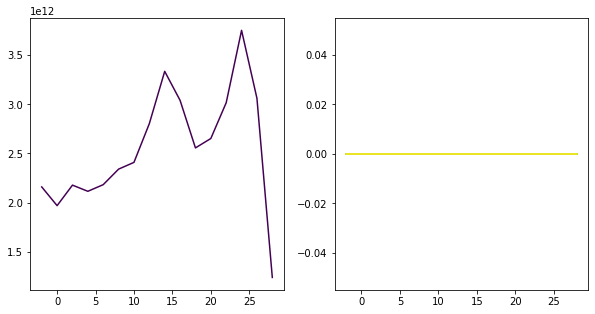

In [21]:
colors = plt.cm.viridis(np.linspace(0,1,12))
default_cycler = cycler(color=colors)
plt.rc('axes',prop_cycle = default_cycler)

volcell_in_theta_anom = volcell_in_theta_sum-np.repeat(volcell_in_theta_sum[0,:,np.newaxis],12,axis=1).transpose()

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
ax[0].plot(theta_bins[:-1],phyC_in_theta_sum.transpose());
ax[1].plot(theta_bins[:-1],volcell_in_theta_anom.transpose());

In [81]:
np.repeat(volcello_in_theta_sum[0,:,np.newaxis],12,axis=1).shape

(15, 12)

In [17]:
def weightedsum(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedsum = variable_times_weights.sum()
    return weightedsum

def weightedmean(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    return weightedmean

def weightedstd(ds,variable,weights):
    # variable and weights are strings
    M = ds[variable].size
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    numerator = ds[weights]*(ds[variable]-weightedmean)**2
    numerator = numerator.sum()
    denominator = ((M-1)/M)*ds[weights].sum()
    weightedstd = numerator/denominator
    return weightedstd

In [18]:
phyc_weightedsum = ds_in_theta.apply(weightedsum,variable='phyc',weights='volcello')
phyc_weightedmean = ds_in_theta.apply(weightedmean,variable='phyc',weights='volcello')
phyc_weightedstd = ds_in_theta.apply(weightedstd,variable='phyc',weights='volcello')

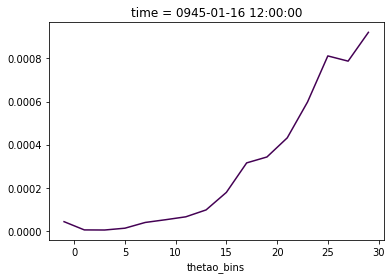

In [23]:
phyc_weightedmean.plot()

In [29]:
ds_cobalt.expc

<xarray.DataArray 'expc' (time: 12, z_l: 35, yh: 576, xh: 720)>
dask.array<shape=(12, 35, 576, 720), dtype=float32, chunksize=(1, 35, 576, 720)>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time     (time) object 0945-01-16 12:00:00 ... 0945-12-16 12:00:00
Attributes:
    long_name:      Sinking Particulate Organic Carbon Flux
    units:          mol m-2 s-1
    cell_measures:  volume: volcello area: areacello
    standard_name:  sinking_mole_flux_of_particulate_organic_matter_expressed...
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean within mont...
    time_avg_info:  average_T1,average_T2,average_DT